### Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.distributions.empirical_distribution import ECDF

### Create common functions
Simple functions that will be used frequently

In [3]:
# Open csv
def open_csv(fname):
    df = pd.read_csv('../csv/' + fname)
    return df

# Save csv
def save_csv(fname):
    pd.to_csv('../csv/' + fname)

# Check missing data percentage
def missing_percentage(df):
    dfCol = df.columns
    missing_dicts = {}
    for col in dfCol:
        missing_dicts[col] = df[col].isna().sum()/len(df[col])
    missingDf = pd.DataFrame(data=zip([key for key in missing_dicts], 
                                      [val[1].round(2) for val in missing_dicts.items()]),
                                      columns=['Columns','Missing Percentage'])
    return missingDf

### Import data and perform basic exploration
There are three main data:
* DA1920_store.csv
    * Contains supplementary information of 1,115 drug stores.
    
    ![store_description](../img/store_description.png)

* DA1920_train.csv
    * Contains the historical sales data from 01/01/2013 to 31/07/2015

    ![train_description](../img/train_description.png)
    
* DA1920_test.csv
    * Identical to train but without sales and customers data.

The goal is to use the train data to build predictive models and forecast the sales of the test data.

In [4]:
store = open_csv('DA1920_store.csv')
train = open_csv('DA1920_train.csv')
test = open_csv('DA1920_test.csv')

In [5]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
 10  Unnamed: 10                0 non-null      float64
 11  Unnamed: 11                1 non-null      object 
dtypes: float64(6), int64(2), object(4)
memory usage: 104.7+ KB


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Store          41088 non-null  int64  
 1   DayOfWeek      41088 non-null  int64  
 2   Date           41088 non-null  object 
 3   Sales          0 non-null      float64
 4   Customers      0 non-null      float64
 5   Open           41077 non-null  float64
 6   Promo          41088 non-null  int64  
 7   StateHoliday   41088 non-null  object 
 8   SchoolHoliday  41088 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 2.8+ MB


The `store` data contains several flaws:
* `CompetitionDistance`, `CompetitionOpenSinceMonth`, `CompetitionOpenSinceYear`, `Promo2SinceWeek`, `Promo2SinceYear`, and `PromoInterval` contains missing data.
* The last two empty columns are useless.

Similarly, `test` data also contains missing data for `Open`; whereas `train` data does not have any missing data.

We can also perform some visualizations to obtain addition details of the data before proceeding to further steps.

In [8]:
train_copy = train.copy()
train_copy['Date'] = pd.to_datetime(train_copy['Date'], infer_datetime_format = True)
train_copy_storecount = pd.DataFrame(train_copy.groupby('Date')['Store'].count()).reset_index()

Set `infer_datetime_format=True` to enable pandas take more accurate guess of the date because current data type for `Date` is string. Without setting this as `True`, the date will mess up. E.g. `2015-07-12` will become `2015-12-07`, while the dataset only consist data up to `2015-07-31`.

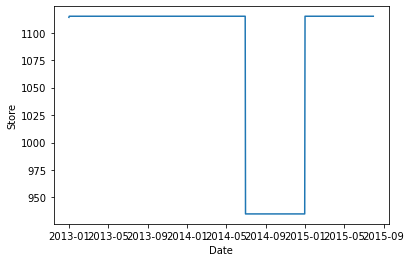

In [9]:
sns.lineplot(x='Date', y='Store', data=train_copy_storecount)

Given `train` dataset has sales data of 1,115 stores for 942 days, it is expected that it contains 1,050,330 observations. However, results from `train.info()` shows there're only 1,017,209 data available. Investigation reveals a six-month gap of missing sales data for 180 stores.

Text(0.5, 1.0, 'Sales Gap for Store 20')

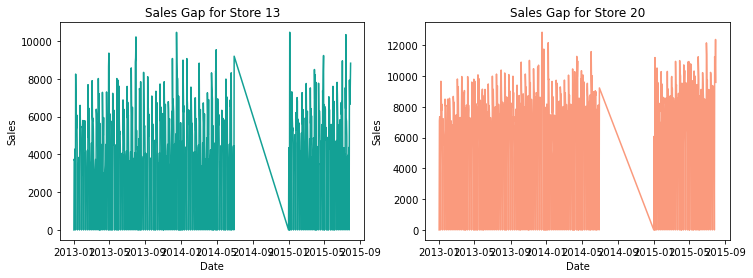

In [10]:
train_copy_store13 = train_copy[train_copy['Store'] == 13]
train_copy_store20 = train_copy[train_copy['Store'] == 20]
fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.lineplot(x='Date', y='Sales', data=train_copy_store13, ax=ax[0], color='#13A195')
ax[0].set_title('Sales Gap for Store 13')
sns.lineplot(x='Date', y='Sales', data=train_copy_store20, ax=ax[1], color='#FA9A7D')
ax[1].set_title('Sales Gap for Store 20')

Some stores do not have sales data from `2014-06-30` to `2015-01-01`. No information were provided to explain the existence of this gap, but it is presumed that these stores were closed temporarily for that period due to extensive renovations or repairs lasting six months.

Let's perform some missing data analysis.

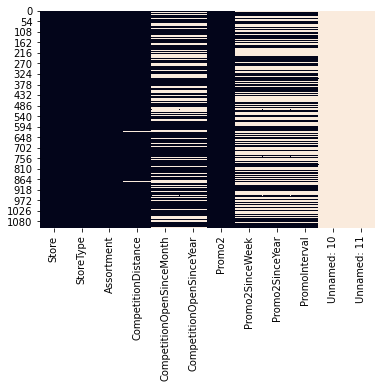

In [11]:
fig, ax = plt.subplots()
sns.heatmap(store.isnull(), cbar=False, ax=ax)

Missing data matrix is very useful to observe at which record the data are missing. Blue color indicates data is available, whereas beige color means there's missing data. More beige color means more missing data (see last two columns). <br>

Visualization package for missing data analysis in Python is rather scarce. Hence, some analysis was conducted in R to generate more interesting plots.

![store_missing](../img/store_missing.png)

Visualize the number of missing data of each variable using `ggplot2`. In addition to this, we can also check the missing percentage to grasp more detail information.

In [12]:
missing_percentage(store)

Columns  Missing Percentage
0                       Store                0.00
1                   StoreType                0.00
2                  Assortment                0.00
3         CompetitionDistance                0.00
4   CompetitionOpenSinceMonth                0.32
5    CompetitionOpenSinceYear                0.32
6                      Promo2                0.00
7             Promo2SinceWeek                0.49
8             Promo2SinceYear                0.49
9               PromoInterval                0.49
10                Unnamed: 10                1.00
11                Unnamed: 11                1.00

![promotion_missing](../img/promo_missing.png)

Visualize the missing data in `Promo2SinceYear`, `Promo2SinceWeek`, and `PromoInterval` across different store types. The density plots reveals majority of stores under type B do not have continuous promotions.

Text(0.5, 1.0, 'PromoInterval')

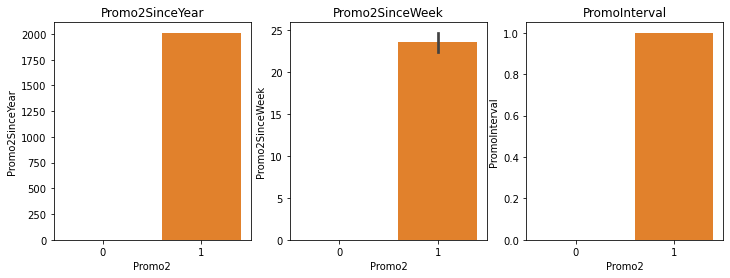

In [13]:
store_copy = store.copy()
store_copy['PromoInterval'] = store_copy['PromoInterval'].apply(lambda x: np.NaN if x is np.NaN else 1)
fig, ax = plt.subplots(1,3, figsize=(12,4))
sns.barplot(x='Promo2', y='Promo2SinceYear', data=store,ax=ax[0])
ax[0].set_title('Promo2SinceYear')
sns.barplot(x='Promo2', y='Promo2SinceWeek', data=store,ax=ax[1])
ax[1].set_title('Promo2SinceWeek')
sns.barplot(x='Promo2', y='PromoInterval', data=store_copy,ax=ax[2])
ax[2].set_title('PromoInterval')

The barplot above shows if a store contains 0 in `Promo2` then it is observed with `NA` in `Promo2SinceYear`, `Promo2SinceWeek`, and `PromoInterval`.

![competition_missing](../img/competition_missing.png)

`NA` observed in `CompetitionOpenSinceYear` was found to correspond with `NA` in `CompetitionOpenSinceMonth`.

### Exploratory Data Analysis
Performs some EDAs before proceed to preprocessing to avoid distorting data and lead to bias analysis outcomes.

**Sales and customers cumulative distribution**

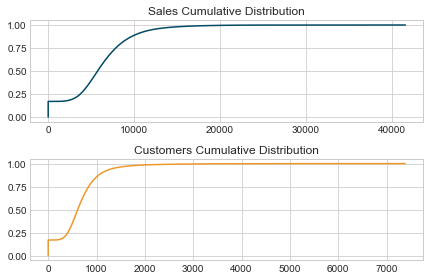

In [61]:
sales_cdf = ECDF(train['Sales'])
cust_cdf = ECDF(train['Customers'])
fig, ax = plt.subplots(2,2, figsize=(6, 4))
plt.subplot(211)
plt.plot(sales_cdf.x, sales_cdf.y, color='#004962')
plt.title('Sales Cumulative Distribution')
plt.subplot(212)
plt.plot(cust_cdf.x, cust_cdf.y, color='#EE982B')
plt.title('Customers Cumulative Distribution')
plt.tight_layout()

Cumulative distribution shows that more than 50% of stores make below 10,000 daily sales (red) and almost 90% of stores have less than 1,000 daily customers (green).

**Sales and customers seasonal patterns**

In [15]:
# Sales
trainSales = train_copy[['Sales']]
trainSales.index = train_copy.Date
avgSales = trainSales.resample('M').mean()
deltaSales = trainSales.resample('M').sum().pct_change()

# Customers
trainCust = train_copy[['Customers']]
trainCust.index = train_copy.Date
avgCust = trainCust.resample('M').mean()
deltaCust = trainCust.resample('M').sum().pct_change()

Text(0.5, 0.98, 'Seasonal Patterns of Sales and Customers')

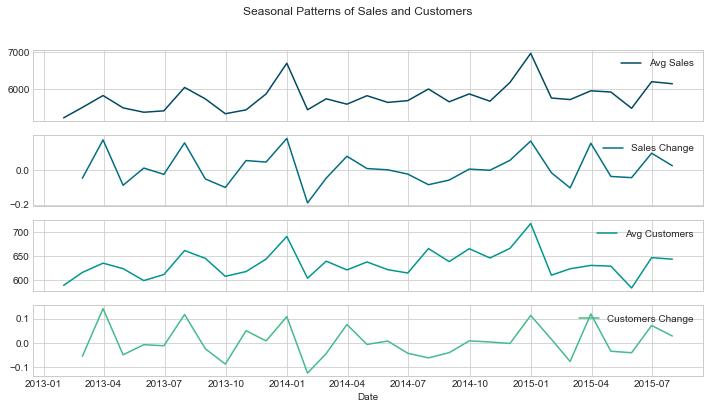

In [60]:
fig, ax = plt.subplots(4,1,figsize=(12,6), sharex=True)
sns.lineplot(x=avgSales.index, y='Sales', data=avgSales, ax=ax[0], color='#004962', label='Avg Sales')
ax[0].set(ylabel=None)
ax[0].legend(loc='upper right')
sns.lineplot(x=deltaSales.index, y='Sales', data=deltaSales, ax=ax[1], color='#006F80', label='Sales Change')
ax[1].set(ylabel=None)
ax[1].legend(loc='upper right')
sns.lineplot(x=avgCust.index, y='Customers', data=avgCust, ax=ax[2], color='#00968D', label='Avg Customers')
ax[2].set(ylabel=None)
ax[2].legend(loc='upper right')
sns.lineplot(x=deltaCust.index, y='Customers', data=deltaCust, ax=ax[3], color='#42BC89', label='Customers Change')
ax[3].set(ylabel=None)
ax[3].legend(loc='upper right')
plt.suptitle('Seasonal Patterns of Sales and Customers')

The seasonal pattern of sales in terms of average sales and percentage change over time from Jan 2013 to Jul 2015 is very similar to the same values for customers. This indicates sales and customers are highly correlated.

In [17]:
# Sales
trainSales = train_copy[['Sales']]
trainSales.index = train_copy.Date
qSales = trainSales.resample('Q').mean()

# Customers
trainCust = train_copy[['Customers']]
trainCust.index = train_copy.Date
qCust = trainCust.resample('Q').mean()

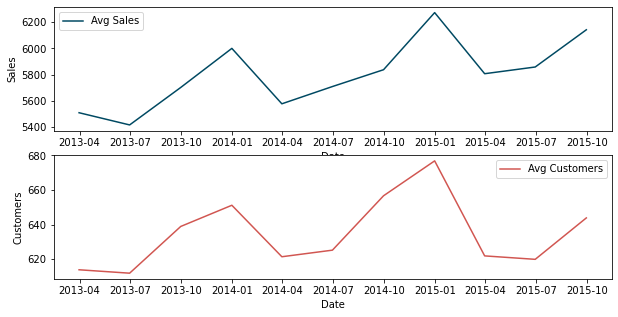

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(10,5))
sns.lineplot(x=qSales.index, y='Sales', data=qSales, color='#004962', label='Avg Sales', ax=ax[0])
sns.lineplot(x=qCust.index, y='Customers', data=qCust, color='#D15651', label='Avg Customers', ax=ax[1])

Looking the data by quarter, it can be observed that both sales and customers are the lowest during the spring season and it slowly increased from summer onwards until it reached the peak during the winter season.

**Weekday and weekend sales**

In [19]:
day = {1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
daySales = pd.DataFrame(train.groupby('DayOfWeek')['Sales'].mean()).reset_index()
daySales['DayOfWeek'] = daySales['DayOfWeek'].replace(day)
daySales.set_index(['DayOfWeek'], inplace=True)

Text(0, 0.5, 'Avg Sales')

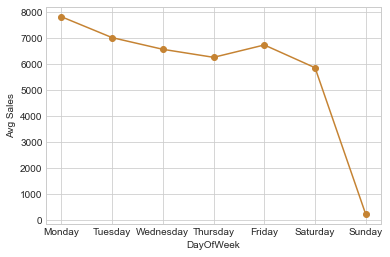

In [20]:
plt.style.use('seaborn-whitegrid')
plt.plot(daySales.index, daySales.Sales, marker='o', color='#C58333')
plt.xlabel('DayOfWeek')
plt.ylabel('Avg Sales')

Majority of stores experience a decline in sales as the weekend approach. 

In [21]:
box_daySales = train_copy.copy()
box_daySales['Year'] = pd.DatetimeIndex(box_daySales['Date']).year
box_daySales['DayOfWeek'] = train['DayOfWeek'].apply(lambda x: 'Weekend' if (x == 6 or x == 7) else 'Weekday')

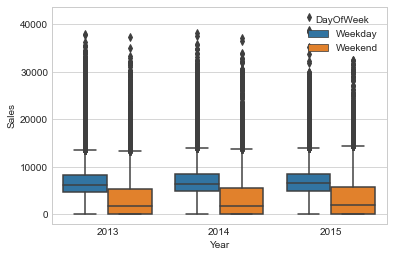

In [22]:
sns.boxplot(x='Year', y='Sales', hue='DayOfWeek', data=box_daySales)

There is large variation for weekend sales as observed in the boxplots. 


In [23]:
store85 = train_copy[train_copy['Store'] == 85]
store85['DayOfWeek'] = store85['DayOfWeek'].apply(lambda x: 'Weekend' if (x == 6 or x == 7) else 'Weekday')

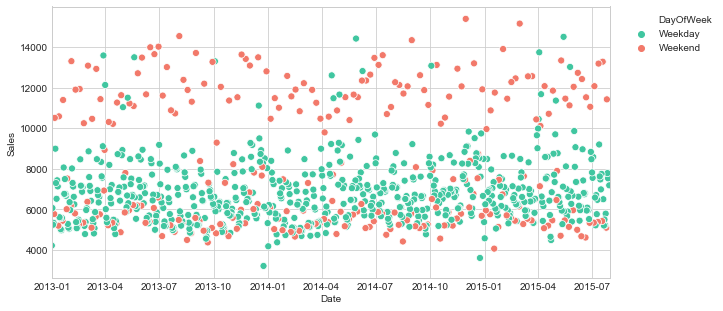

In [24]:
palette = ['#40C6A0', '#F2796A']
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(x='Date', y='Sales', hue='DayOfWeek', data=store85, ax=ax, s=50, palette=palette)
ax.set(xlim=(pd.to_datetime('2013-01-01'), pd.to_datetime('2015-07-31')))
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

Store that operates on Sunday has higher sales as compared to weekday sales.

**Sales during state and school holiday**

In [25]:
# State Holiday
holiday = train_copy.copy()
holiday['StateHoliday'] = holiday['StateHoliday'].apply(lambda x: 0 if (x == '0' or x == 0) else 1)

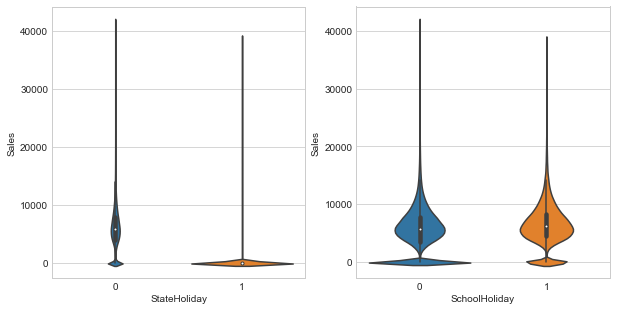

In [26]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.violinplot(x='StateHoliday', y='Sales', data=holiday, ax=ax[0])
sns.violinplot(x='SchoolHoliday', y='Sales', data=holiday, ax=ax[1])

There're distinct difference in sales between state holidays but not much difference for school holiday.

### Preprocessing
Perform some simple preprocessing and merge `store` with `train` and `test` dataset. After this we can perform more exhaustive EDA.

In [27]:
# Drop last two columns of store dataset
store = store.iloc[:, :-2]

In [28]:
# Merge store with train and test dataset
mtrain = store.merge(train, how='inner')
mtest = store.merge(test, how='inner')

In [29]:
# Convert date format
mtrain_copy = mtrain.copy()
mtrain_copy['Date'] = pd.to_datetime(mtrain_copy['Date'], infer_datetime_format = True)

**Sales by store type**

In [30]:
storetype_sales = pd.DataFrame(mtrain_copy.groupby(['StoreType', 'DayOfWeek'])['Sales'].mean()).reset_index()
storetype_sales['DayOfWeek'] = storetype_sales['DayOfWeek'].replace(day)

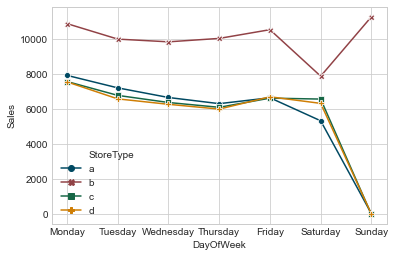

In [63]:
palette=['#004962', '#914246', '#176746', '#CF7E05']
sns.lineplot(x='DayOfWeek', y='Sales', hue='StoreType', data=storetype_sales, markers=True, style='StoreType', dashes=False, sort=False, palette=palette)

All store type have sales decline on Sunday, except for store type B.

In [32]:
sh = {'a':'Public', 'b':'Easter', 'c':'Christmas', 0:'0'}
stype_holiday_sales = pd.DataFrame(mtrain_copy.groupby(['StoreType','StateHoliday'])['Sales'].mean()).reset_index()
stype_holiday_sales['StateHoliday'] = stype_holiday_sales['StateHoliday'].replace(sh)

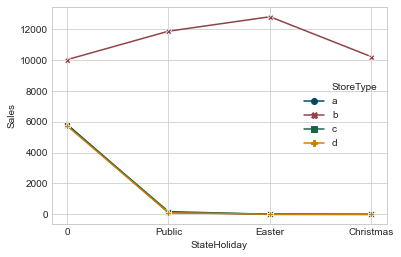

In [64]:
sns.lineplot(x='StateHoliday', y='Sales', hue='StoreType', data=stype_holiday_sales, markers=True, style='StoreType', dashes=False, sort=False, palette=palette)

Generally store type B has higher sales than others, especially during Public, Easter, and Christmas holiday.

In [45]:
stype_sales = mtrain_copy[['StoreType', 'Sales']]
stype_sales.index = mtrain_copy['Date']
stype_sales['Month'] = pd.DatetimeIndex(stype_sales.index).month
stype_salesG = pd.DataFrame(stype_sales.groupby(['Month','StoreType'])['Sales'].mean()).reset_index()

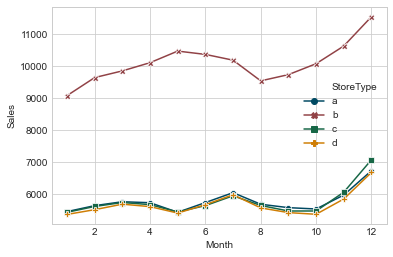

In [65]:
sns.lineplot(x='Month', y='Sales', hue='StoreType', data=stype_salesG, markers=True, style='StoreType', dashes=False, palette=palette)

Store type B has higher average sales across every month compared to other stores. Besides, store type B also shows a smoother rise and decline in sales than A, C, and D throughout the months. Hence, we will expect sales forecasts for store type B to be different from other types during first three quarters (January to September) of the year, but similar to the other types for the last quarter (October to December). 


**Promotion effects on sales**

In [74]:
promo_sales = mtrain_copy[['Sales', 'Promo', 'Promo2']]
promo_sales.index = mtrain_copy.Date
promo_sales['Month'] = pd.DatetimeIndex(promo_sales.index).month
promo_sales['Year'] = pd.DatetimeIndex(promo_sales.index).year

In [79]:
promo_salesG = pd.DataFrame(promo_sales.groupby(['Year', 'Month','Promo', 'Promo2'])['Sales'].mean()).reset_index()

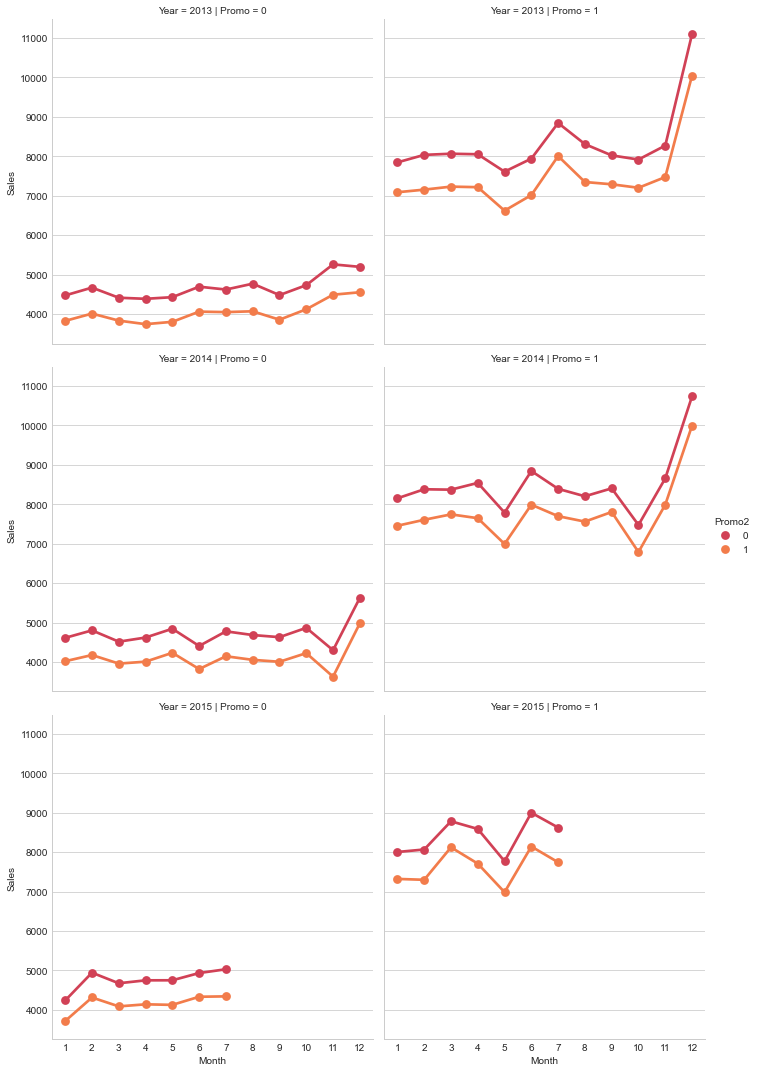

In [113]:
palette = ['#D14156', '#F27C4B']
sns.catplot(data=promo_salesG, x='Month', y='Sales', hue='Promo2', col='Promo', row='Year', kind='point', palette=palette)

Key findings includes:-
* Store-specific promotion on a given day (Promo) significantly increases sales, especially during winter season.
* Surprisingly, stores with consecutive promotions (Promo2) make lesser sales than stores with no consecutive promotions.

Let's do some feature engineering by creating `Avg Sales per Customer` and see if promo have effects on this.

In [89]:
mtrain_copy['Avg Sales per Customer'] = mtrain['Sales']/mtrain['Customers']


In [91]:
promo_salescust = mtrain_copy[['Avg Sales per Customer', 'Promo', 'Promo2']]
promo_salescust.index = mtrain_copy.Date
promo_salescust['Month'] = pd.DatetimeIndex(promo_salescust.index).month
promo_salescust['Year'] = pd.DatetimeIndex(promo_salescust.index).year
promo_salescustG = pd.DataFrame(promo_salescust.groupby(['Year', 'Month','Promo', 'Promo2'])['Avg Sales per Customer'].mean()).reset_index()

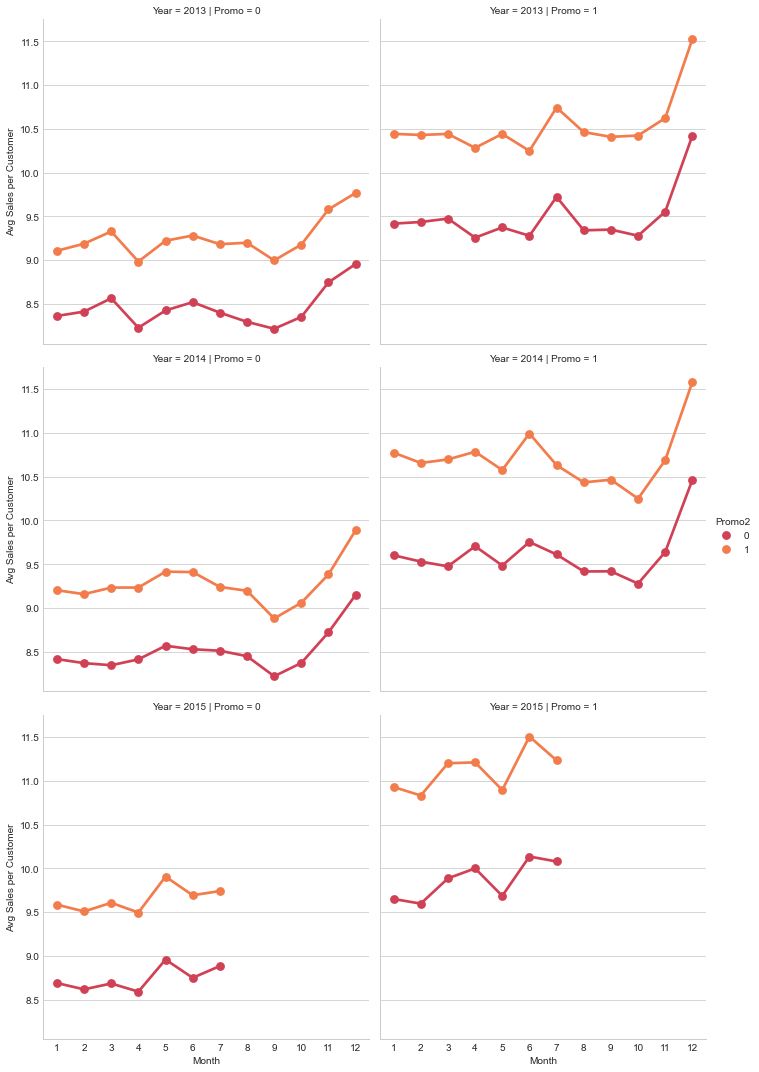

In [112]:
sns.catplot(data=promo_salescustG, x='Month', y='Avg Sales per Customer', hue='Promo2', col='Promo', row='Year', kind='point', palette=palette)

Different from sales, consecutive promotion (Promo2) helped increases average sales per customer. Similarly, daily promotion (Promo) also has the same effect. <br>
Let's see how promo varies on weekday and weekend.

In [98]:
promo_day = mtrain_copy[['Sales', 'DayOfWeek', 'Promo', 'Promo2']]
promo_day['DayOfWeek'] = promo_day['DayOfWeek'].replace(day)
promo_dayG = pd.DataFrame(promo_day.groupby(['DayOfWeek', 'Promo2', 'Promo'])['Sales'].mean()).reset_index()

In [115]:
promoc_day = mtrain_copy[['Avg Sales per Customer', 'DayOfWeek', 'Promo', 'Promo2']]
promoc_day['DayOfWeek'] = promoc_day['DayOfWeek'].replace(day)
promoc_dayG = pd.DataFrame(promoc_day.groupby(['DayOfWeek', 'Promo2', 'Promo'])['Avg Sales per Customer'].mean()).reset_index()

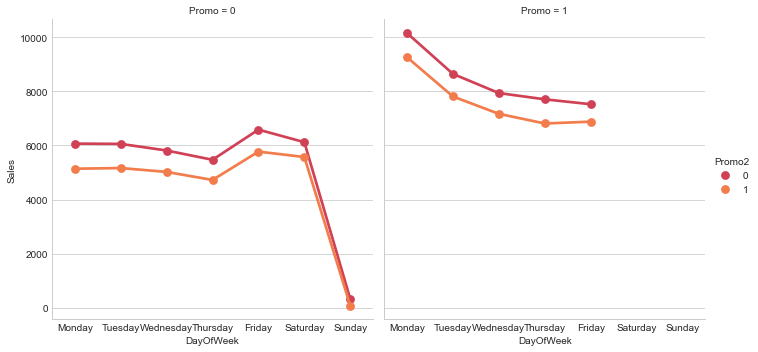

In [111]:
sns.catplot(data=promo_dayG, x='DayOfWeek', y='Sales', hue='Promo2', col='Promo', palette=palette, kind='point', order=[val[1] for val in day.items()])

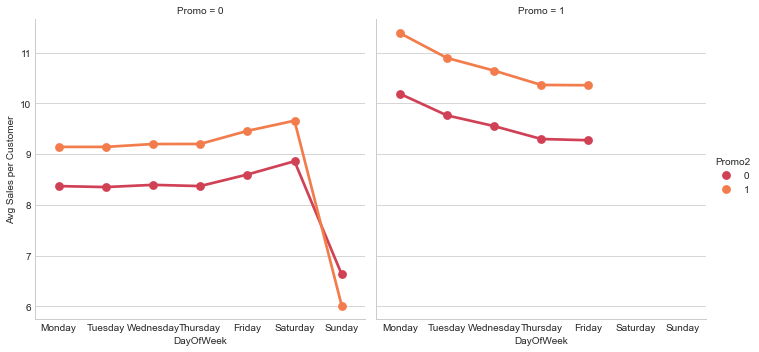

In [116]:
sns.catplot(data=promoc_dayG, x='DayOfWeek', y='Avg Sales per Customer', hue='Promo2', col='Promo', palette=palette, kind='point', order=[val[1] for val in day.items()])

Promotions have the same effect as described above for daily average sales and sales per customers. Besides, it is also noticeable that store-specific promotion was not carried out on weekends. 

**Assortment Analysis**
We already see how sales varies by store type and promo, let's have a look on sales difference between different assortment level.